## Table of Contents
1. Importing libraries
2. Reading data, setting up
3. Creating region column, assigning values
4. Creating exclusion flag for low-activity customers
5. Creating customer profiles
    - Age
    - Income
    - Children
    - Nutrition style
    - Order timing
6. Visualizing profile distributions
7. Descriptive statistics on customer profile level
8. Visualizing regional profile differences
9. Visualizing profile differences in department preferences

### 1. Importing libraries

In [89]:
# importing libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy

### 2. Reading data, setting up

In [1]:
# Importing data
# setting up filepaths, reading data
path = r'C:\Users\Richárd\Desktop\CareerFoundry\Data Immersion\Archievment 4\Instacart_Basket_Analysis_2023_04_03\02_Data\Prepared_Data'
viz_path = r'C:\Users\Richárd\Desktop\CareerFoundry\Data Immersion\Archievment 4\Instacart_Basket_Analysis_2023_04_03\04_Analysis\Visualizations'
df_merged = pd.read_pickle(os.path.join(path, 'full_data.pkl'))
df_merged.shape

SyntaxError: invalid syntax (3811604629.py, line 1)

In [91]:
df_merged.shape

(32404859, 31)

In [92]:
df_merged.columns

Index(['order_id', 'user_id', 'order_number', 'orders_day_of_the_week',
       'order_hour_of_day', 'days_after_previous_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'prices', '_merge', 'price_range', 'busiest_day',
       'busiest_days', 'busiest_period_of_day', 'max_orders', 'loyality_flag',
       'avg_spending', 'spending_flag', 'median_days_between_orders',
       'order_frequency_flag', 'gender', 'state', 'age', 'date_joined',
       'number_of_dependants', 'family_status', 'income'],
      dtype='object')

### 3. Creating region column, assigning values

In [94]:
# Idenditfying regional differences
# Creating list of regions, containing state names
northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
midwest = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
south = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
west = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']


In [95]:
# creating an ordered list from state column
states = df_merged['state'].tolist()
# Assigning region flags to a list
region_flags = []

In [96]:
# Assigning region flags to a list
for row in states:
    if row in northeast:
        region_flags.append('Northeast')
    elif row in midwest:
        region_flags.append('Midwest')
    elif row in south:
        region_flags.append('South')
    elif row in west:
        region_flags.append('West')
    else:
        print('Error: Cannot recognize state')

In [97]:
# creating a new region column from region_flags list
df_merged['region'] = region_flags


In [98]:
# creating crosstab to analyze regional spending differences
regional_spending_crosstab = pd.crosstab(df_merged['region'], df_merged['spending_flag'], dropna = False)

In [99]:
# copying crosstab to clipboard
regional_spending_crosstab.to_clipboard()

In [100]:
regional_spending_crosstab.head()

spending_flag,High spender,Low spender
region,,
Midwest,29265,7568060
Northeast,18642,5704094
South,40579,10751306
West,31242,8261671


### Regional spending habits key takeaways
1. The proportion of high spenders is sub 1% across the regions, differences are marginal at best
2. Instacart is most popular in the West and Midwest (judging by the portion of population using instacart)
3. South brings the most customers, but inly because its a way more popolous region than the others

### 4. Creating exclusion flag for low-activity customers

In [101]:
# Creating exclusion flag for low-activity customers
df_low_spenders_excluded = df_merged[df_merged['max_orders'] >= 5]

In [102]:
df_low_spenders_excluded.shape

(30964564, 32)

In [103]:
# Exporting subset to pickle
df_low_spenders_excluded.to_pickle(os.path.join(path, 'full_data_without_low_spenders.pkl'))

### 5. Creating customer profiles
Flags to be created: age, income, certain goods in the “department_id” column, and number of dependents.
1. Age: Young (<=25), Middle-Aged(26-59), Senior (60+)
2. Income: Low-income (<40.000) Mid-income (40.000-100000) High-income (100.000+)
3. num_dependents: No children (0), parent(1+)
4. departments: Meat-consumer, Vegetarian (no no. 12), Vegan (no 12 and 16)
5. Day of week: Weekday customer (most orders bw. 0-4) Weekend customer (most orders bw 5-6)

In [104]:
# Creating customer profiles
# Age Flag
age_flag = []
for row in df_merged['age'].tolist():
    if row <= 25:
        age_flag.append('Young')
    elif row > 25 and row < 60:
        age_flag.append('Middle-aged')
    elif row >= 60:
        age_flag.append('Senior')
    else:
        print('Weird value:', row)

In [105]:
df_merged['age_profile'] = age_flag


In [106]:
# Income flag
income_flag = []
for row in df_merged['income'].tolist():
    if row < 40000:
        income_flag.append('Low-income')
    elif row >= 40000 and row < 100000:
        income_flag.append('Mid-income')
    elif row >= 100000:
        income_flag.append('High-income')
    else:
        print('Weird value:', row)

In [107]:
df_merged['income_profile'] = income_flag

In [108]:
# children flag
child_flag = []
for row in df_merged['number_of_dependants'].tolist():
    if row == 0:
        child_flag.append('No children')
    elif row > 0:
        child_flag.append('Parent')
    else:
        print('Weird value:', row)

In [109]:
df_merged['children'] = child_flag

In [110]:
# Nutrition style
nutr_crosstab = pd.crosstab(df_merged['department_id'], df_merged['user_id'], dropna = False)

In [111]:
# Assigning nutrition flags to isers and storing it in a pyton dictionary
nutr_dict = dict()
for user in nutr_crosstab:
    workinglist = nutr_crosstab[user].tolist()
    if workinglist[11] == 0 and workinglist[15] == 0:
        nutr_dict[user] = 'Vegan'
    elif workinglist[11] == 0:
        nutr_dict[user] = 'Vegetarian'
    else:
        nutr_dict[user] = 'Meat-consumer'

In [112]:
# assigning user flags to the list
nutr_list = []
for user in df_merged['user_id']:
    nutr_list.append(nutr_dict[user])

In [113]:
# creating nutrition profile column
df_merged['nutrition_profile'] = nutr_list

In [114]:
# Creating profile on a week of the day basis
week_crosstab = pd.crosstab(df_merged['orders_day_of_the_week'], df_merged['user_id'], dropna = False)

In [115]:
week_dict = dict()
for user in week_crosstab:
    workinglist = week_crosstab[user].tolist()
    if workinglist[0] + workinglist[1] >= sum(workinglist[:4]):
        week_dict[user] = 'Weekend customer'
    else:
        week_dict[user] = 'Weekday customer'
    
        
    

In [116]:
week_flags = []
for user in df_merged['user_id']:
    week_flags.append(week_dict[user])

In [117]:
df_merged['days_of_order_profile'] = week_flags

In [118]:
# setup user profiles dataframe
df_profiles = df_merged[['user_id', 'age_profile', 'income_profile', 'children', 'nutrition_profile', 'days_of_order_profile', 'region', 'loyality_flag', 'spending_flag', 'order_frequency_flag', 'family_status']]

In [119]:
df_customer_profiles = df_profiles.groupby('user_id').first()

### 6. Visualizing profile distributions

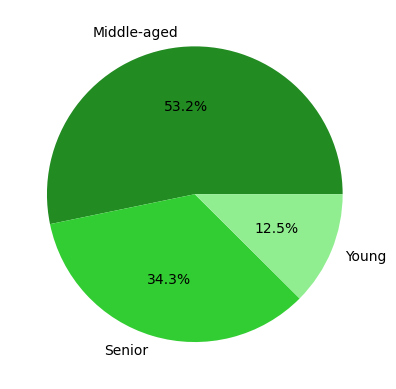

In [120]:
# Visualizing profiles
# Age Flag Visualization
plt.pie(df_customer_profiles['age_profile'].value_counts(), autopct='%1.1f%%', labels = df_merged['age_profile'].unique(), colors = ['forestgreen', 'limegreen', 'lightgreen'])
plt.savefig(os.path.join(viz_path, 'age_profiles_pie.png'))

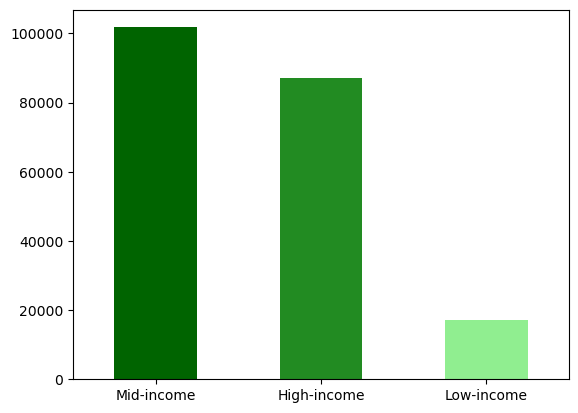

In [121]:
# Income flag visualization
df_customer_profiles['income_profile'].value_counts().plot.bar(color = ['darkgreen', 'forestgreen', 'lightgreen'],)
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'income_profile_distribution.png'))

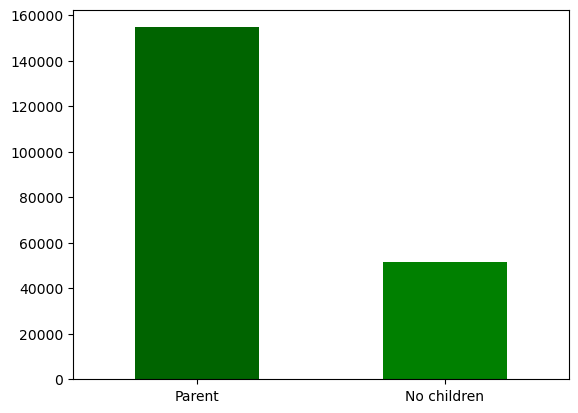

In [122]:
df_customer_profiles['children'].value_counts().plot.bar(color = ['darkgreen', 'green'])
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'family_profile_distribution.png'))

In [123]:
df_customer_profiles['nutrition_profile'].value_counts()

Meat-consumer    113891
Vegetarian        79069
Vegan             13249
Name: nutrition_profile, dtype: int64

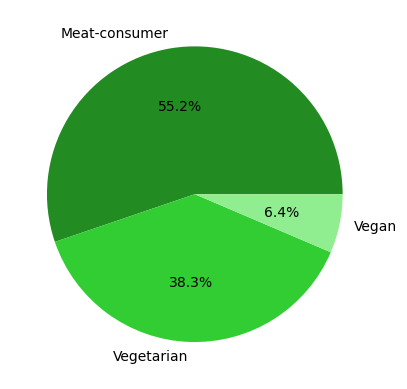

In [124]:
# Nutrition style visualization
plt.pie(df_customer_profiles['nutrition_profile'].value_counts(), autopct='%1.1f%%', labels = ['Meat-consumer', 'Vegetarian', 'Vegan'], colors = ['forestgreen', 'limegreen', 'lightgreen'])
plt.savefig(os.path.join(viz_path, 'nutrition_pie.png'))

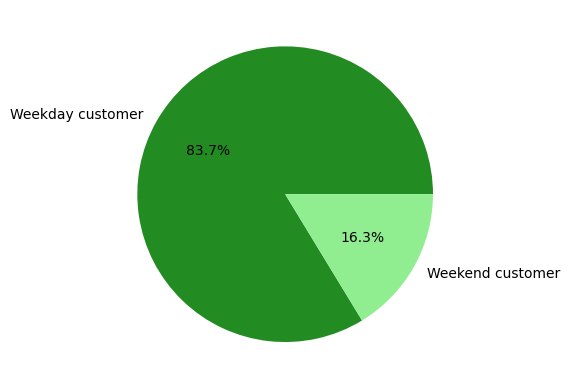

In [125]:
plt.pie(df_customer_profiles['days_of_order_profile'].value_counts(), autopct='%1.1f%%', labels = df_customer_profiles['days_of_order_profile'].unique(), colors = ['forestgreen', 'lightgreen'])
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'day_of_order_preference.png'))

### 7. Descriptive statistics on customer profile level

In [126]:
# Across age groups
df_merged.groupby('age_profile').agg({'prices': ['mean', 'max', 'min'], 'days_after_previous_order': ['mean', 'max', 'min']})
# Spending and order-frequency habits are similar across age groups

prices            days_after_previous_order           
                 mean   max  min                      mean   max  min
age_profile                                                          
Middle-aged  7.789458  25.0  1.0                 11.114039  30.0  0.0
Senior       7.795312  25.0  1.0                 11.092552  30.0  0.0
Young        7.785748  25.0  1.0                 11.093030  30.0  0.0

In [127]:
# Across Income groups
df_merged.groupby('income_profile').agg({'prices': ['mean', 'max', 'min'], 'days_after_previous_order': ['mean', 'max', 'min']})
# Low income customers understandably tend to order a bit cheaper than the rest, no real difference among income groups in order frequency

prices            days_after_previous_order           
                    mean   max  min                      mean   max  min
income_profile                                                          
High-income     7.959256  25.0  1.0                 11.039852  30.0  0.0
Low-income      6.495264  25.0  1.0                 11.686944  30.0  0.0
Mid-income      7.774984  25.0  1.0                 11.101346  30.0  0.0

In [128]:
# Children
df_merged.groupby('children').agg({'prices': ['mean', 'max', 'min'], 'days_after_previous_order': ['mean', 'max', 'min']})
# spending and order frequency habits are similar amond those who have children, and those who do not.

prices            days_after_previous_order           
                 mean   max  min                      mean   max  min
children                                                             
No children  7.789975  25.0  1.0                 11.080805  30.0  0.0
Parent       7.791334  25.0  1.0                 11.111834  30.0  0.0

In [129]:
# Nutrition Style
df_merged.groupby('nutrition_profile').agg({'prices': ['mean', 'max', 'min'], 'days_after_previous_order': ['mean', 'max', 'min']})
# There are mild differences between spending habits, Meat-consumers spend the most, while Vegans the least. Vegans seem to order less frequently than the rest

prices            days_after_previous_order           
                       mean   max  min                      mean   max  min
nutrition_profile                                                          
Meat-consumer      7.905951  25.0  1.0                 10.762605  30.0  0.0
Vegan              7.009920  20.0  1.0                 14.749275  30.0  0.0
Vegetarian         7.496501  20.0  1.0                 11.952600  30.0  0.0

In [130]:
# Day of order
df_merged.groupby('days_of_order_profile').agg({'prices': ['mean', 'max', 'min'], 'days_after_previous_order': ['mean', 'max', 'min']})
# There is no real spending difference between weekday and weekend customers. Weekend customers tend to order less frequently than weekday customers. 

prices            days_after_previous_order        \
                           mean   max  min                      mean   max   
days_of_order_profile                                                        
Weekday customer       7.786643  25.0  1.0                 10.776765  30.0   
Weekend customer       7.850013  25.0  1.0                 16.068039  30.0   

                            
                       min  
days_of_order_profile       
Weekday customer       0.0  
Weekend customer       0.0

### 8. Visualizing regional profile differences

#### Regional differences among profiles

In [131]:
# Regional age differences
regional_age_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['age_profile'], dropna = False)

In [132]:
cmap = plt.colormaps['summer']
cmap2 = plt.colormaps['gnuplot']

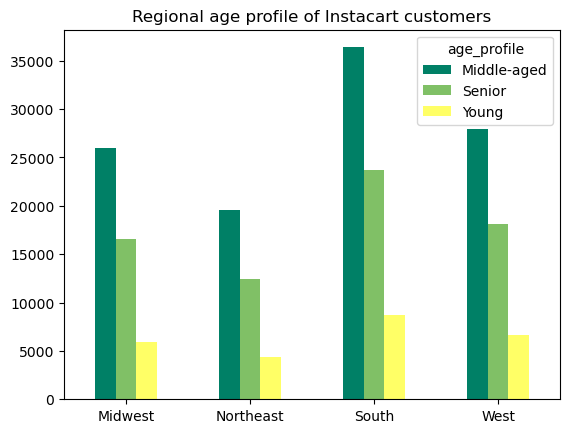

In [133]:
regional_age_crosstab.plot(kind = 'bar', stacked = False, title = 'Regional age profile of Instacart customers', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'regional_age_distribution_bar.png'))

In [134]:
# Regional income differences
regional_income_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['income_profile'], dropna = False)

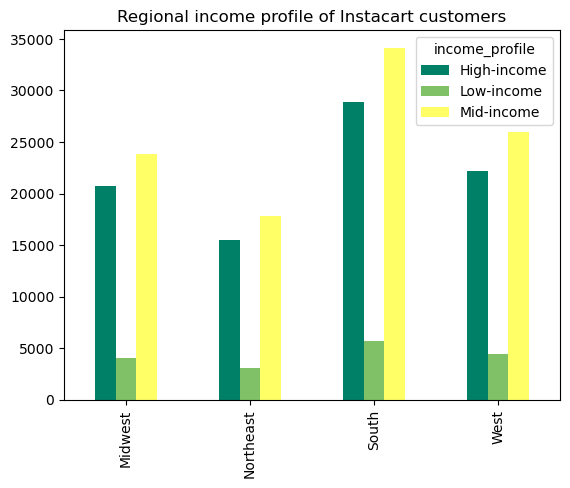

In [135]:
regional_income_bar = regional_income_crosstab.plot(kind = 'bar', stacked = False, title = 'Regional income profile of Instacart customers', cmap = cmap, xlabel = '')

In [136]:
# Regional family status differences
regional_children_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['children'], dropna = False)

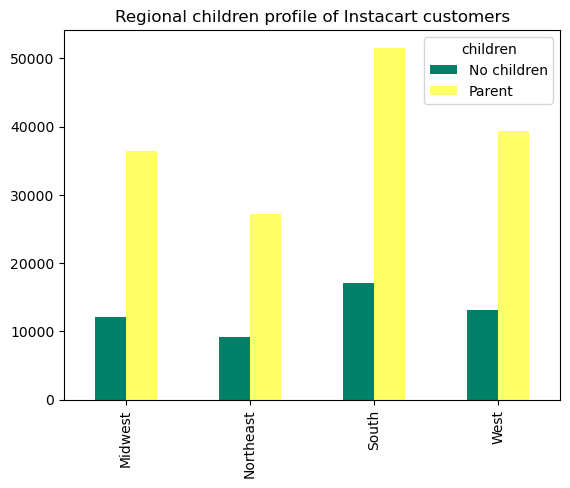

In [137]:
regional_children_bar = regional_children_crosstab.plot(kind = 'bar', stacked = False, title = 'Regional children profile of Instacart customers', cmap = cmap, xlabel = '')

In [138]:
# Regional nutrition style differences
regional_nutrition_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['nutrition_profile'], dropna = False)

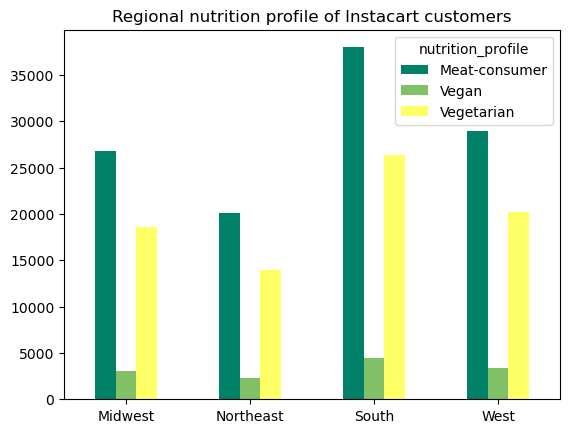

In [139]:
regional_nutrition_crosstab.plot(kind = 'bar', stacked = False, title = 'Regional nutrition profile of Instacart customers', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'regional_nutrition_profiles_bar.png'))

In [140]:
# Regional day of order preference differences
regional_dow_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['days_of_order_profile'], dropna = False)

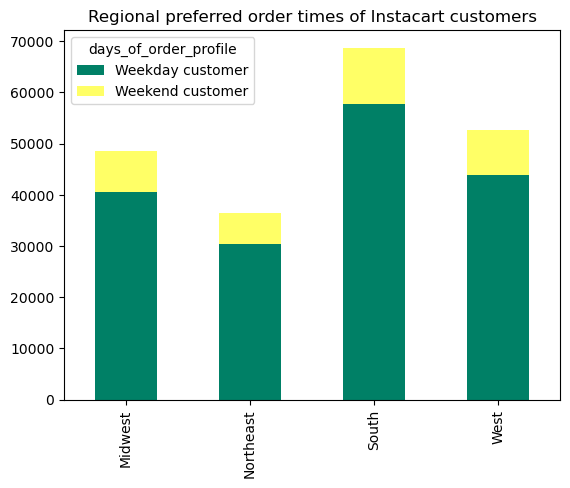

In [141]:
regional_dow_bar = regional_dow_crosstab.plot(kind = 'bar', stacked = True, title = 'Regional preferred order times of Instacart customers', cmap = cmap, xlabel = '')

In [142]:
# Regional loyality differences
regional_loyality_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['loyality_flag'], dropna = False)

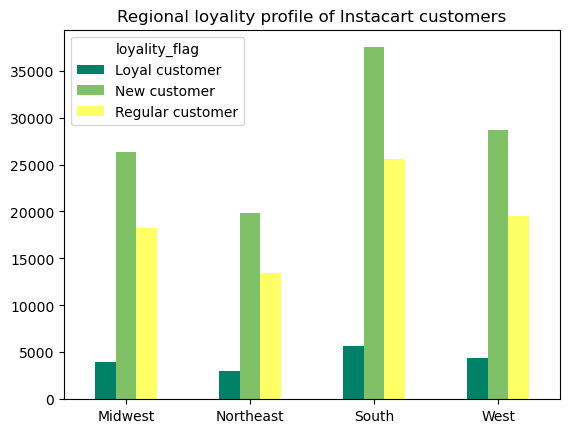

In [143]:
regional_loyality_crosstab.plot(kind = 'bar', stacked = False, title = 'Regional loyality profile of Instacart customers', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'regional_loyality_bar.png'))

In [144]:
# regional spending habit differences
regional_spending_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['spending_flag'], dropna = False)

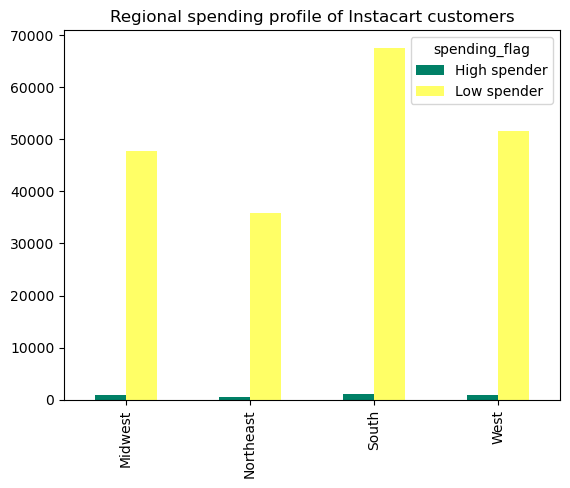

In [145]:
regional_spending_bar = regional_spending_crosstab.plot(kind = 'bar', stacked = False, title = 'Regional spending profile of Instacart customers', cmap = cmap, xlabel = '')

In [146]:
# Regional order frequency differences
regional_frequency_crosstab = pd.crosstab(df_customer_profiles['region'], df_customer_profiles['order_frequency_flag'], dropna = False)

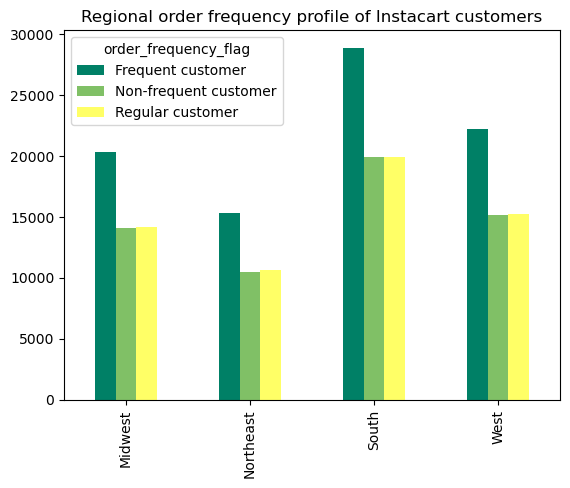

In [147]:
regional_frequency_bar = regional_frequency_crosstab.plot(kind = 'bar', stacked = False, title = 'Regional order frequency profile of Instacart customers', cmap = cmap, xlabel = '')


### 9. Visualizing profile differences in department preferences

In [148]:
# creating subset of profiles nd departments
depts_df = df_merged[['department_id', 'user_id', 'age_profile', 'income_profile', 'children', 'nutrition_profile', 'days_of_order_profile', 'region', 'loyality_flag', 'spending_flag', 'order_frequency_flag', 'family_status']]

In [149]:
# Depertment preferences among age groups
depts_age_crosstab = pd.crosstab(depts_df['department_id'], depts_df['age_profile'], dropna = False)

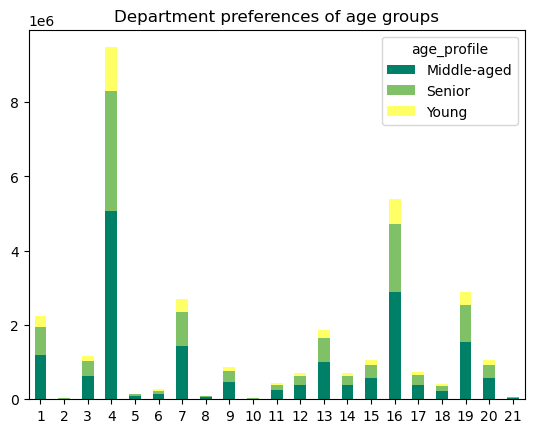

In [150]:
depts_age_bar = depts_age_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of age groups', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'department preferences_bar.png'))

In [151]:
# Depertment preferences among income groups
depts_income_crosstab = pd.crosstab(depts_df['department_id'], depts_df['income_profile'], dropna = False)

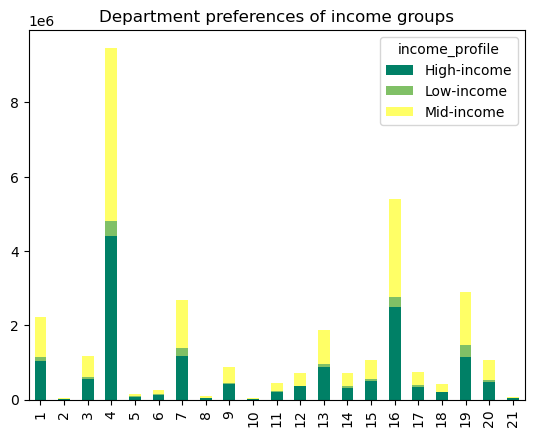

In [152]:
depts_age_bar = depts_income_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of income groups', cmap = cmap, xlabel = '')

In [153]:
# Depertment preferences among family status groups
depts_children_crosstab = pd.crosstab(depts_df['department_id'], depts_df['children'], dropna = False)


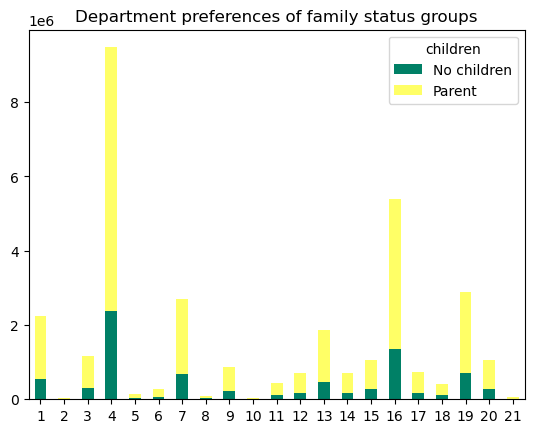

In [154]:
depts_children_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of family status groups', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'department_family_bar.png'))

In [155]:
# Depertment preferences among nutrition style groups
depts_nutrition_crosstab = pd.crosstab(depts_df['department_id'], depts_df['nutrition_profile'], dropna = False)

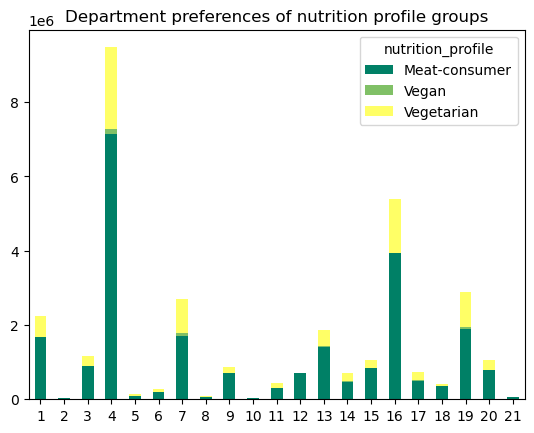

In [156]:
depts_nutrition_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of nutrition profile groups', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'nutrition_department_bar.png'))

In [157]:
# Depertment preferences among order day preference groups
depts_dow_crosstab = pd.crosstab(depts_df['department_id'], depts_df['days_of_order_profile'], dropna = False)

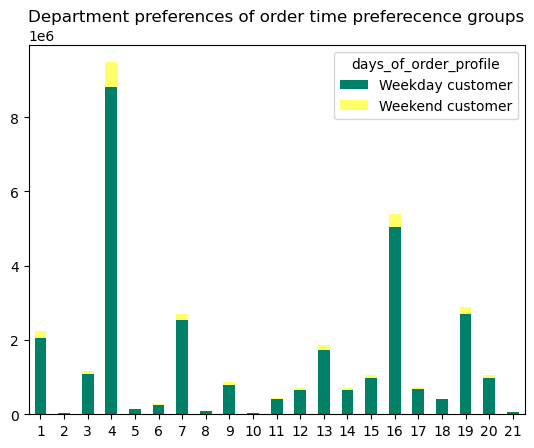

In [158]:
depts_dow_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of order time preferecence groups', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'departmer_order_times_bar.png'))

In [159]:
# Depertment preferences among loyality groups
depts_loyality_crosstab = pd.crosstab(depts_df['department_id'], depts_df['loyality_flag'], dropna = False)

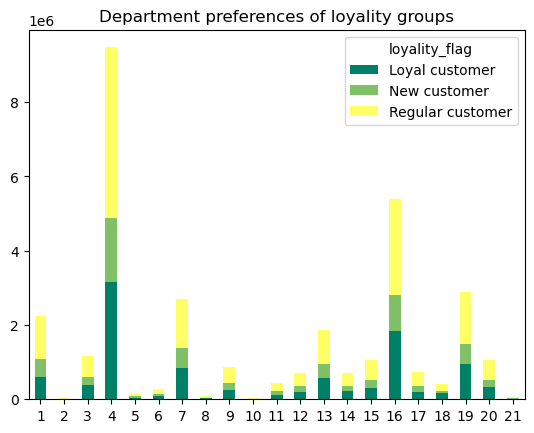

In [160]:
depts_loyality_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of loyality groups', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'loyality_department_bar.png'))

In [161]:
# Depertment preferences among spending habit groups groups
depts_spending_crosstab = pd.crosstab(depts_df['department_id'], depts_df['spending_flag'], dropna = False)

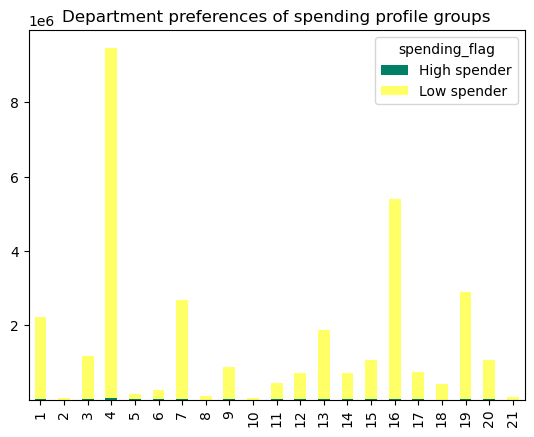

In [162]:
depts_spending_bar = depts_spending_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of spending profile groups', cmap = cmap, xlabel = '')

In [163]:
# Department preferences among order frequency groups
depts_freq_crosstab = pd.crosstab(depts_df['department_id'], depts_df['order_frequency_flag'], dropna = False)

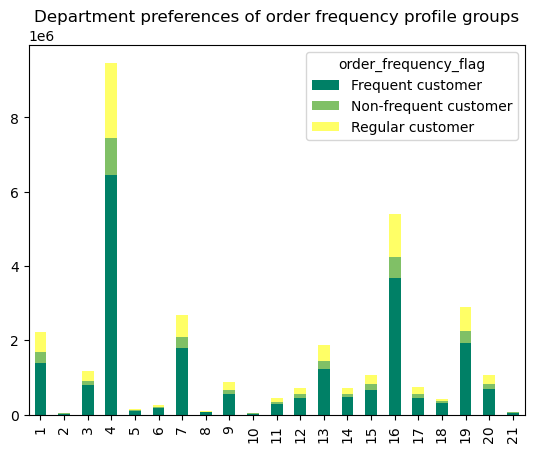

In [164]:
depts_freq_bar = depts_freq_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of order frequency profile groups', cmap = cmap, xlabel = '')

In [ ]:
depts_marry_crosstab.plot(kind = 'bar', stacked = True, title = 'Department preferences of family_status groups', cmap = cmap, xlabel = '')
plt.xticks(rotation = 0)
plt.savefig(os.path.join(viz_path, 'fimily_status_department_bar.png'))

In [165]:
df_merged.columns

Index(['order_id', 'user_id', 'order_number', 'orders_day_of_the_week',
       'order_hour_of_day', 'days_after_previous_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'prices', '_merge', 'price_range', 'busiest_day',
       'busiest_days', 'busiest_period_of_day', 'max_orders', 'loyality_flag',
       'avg_spending', 'spending_flag', 'median_days_between_orders',
       'order_frequency_flag', 'gender', 'state', 'age', 'date_joined',
       'number_of_dependants', 'family_status', 'income', 'region',
       'age_profile', 'income_profile', 'children', 'nutrition_profile',
       'days_of_order_profile'],
      dtype='object')

In [166]:
depts_marry_crosstab = pd.crosstab(depts_df['department_id'], depts_df['family_status'], dropna = False)

In [167]:
df_merged.to_pickle(os.path.join(path, 'final_instacart_data.pkl'))

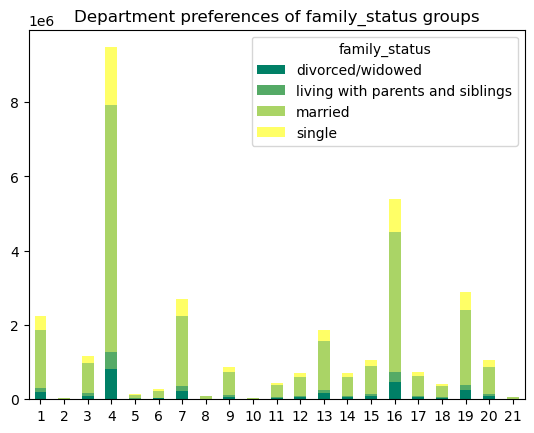